# Using word embeddings

This notebook is based on the code samples found in Chapter 6, Section 1 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff) and hosted on https://github.com/fchollet/deep-learning-with-python-notebooks. 

Note that the original text features far more content, in particular further explanations and figures.

In [1]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

In [0]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
from tensorflow import keras
keras.__version__

'2.2.4-tf'

A popular and powerful way to associate a vector with a word is the use of dense "word vectors", also called "word embeddings". 
While the vectors obtained through one-hot encoding are binary, sparse (mostly made of zeros) and very high-dimensional (same dimensionality as the 
number of words in the vocabulary), "word embeddings" are low-dimensional floating point vectors 
(i.e. "dense" vectors, as opposed to sparse vectors). 
Unlike word vectors obtained via one-hot encoding, word embeddings are learned from data. 
It is common to see word embeddings that are 256-dimensional, 512-dimensional, or 1024-dimensional when dealing with very large vocabularies. 
On the other hand, one-hot encoding words generally leads to vectors that are 20,000-dimensional or higher (capturing a vocabulary of 20,000 
token in this case). So, word embeddings pack more information into far fewer dimensions. 

![word embeddings vs. one hot encoding](https://s3.amazonaws.com/book.keras.io/img/ch6/word_embeddings.png)

There are two ways to obtain word embeddings:

1. Learn word embeddings jointly with the main task you care about (e.g. document classification or sentiment prediction). 
In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.
2. Load into your model word embeddings that were pre-computed using a different machine learning task than the one you are trying to solve. 
These are called "pre-trained word embeddings". 

## Learning word embeddings with the `Embedding` layer


* The simplest way to associate a dense vector to a word would be to pick the vector at random and let the model learn the best values of the vector during the training stage.
* Keras provides the `Embedding` layer that facilitates this.
* The `Embedding` layer is normally the first layer of the neural network.
* The `Embedding` layer takes a word index as input.

In [4]:
from tensorflow.keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes 
as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.


The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of 
integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have 
shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). All sequences in a batch must 
have the same length, though (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded 
with zeros, and sequences that are longer should be truncated.

This layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. Such a 3D tensor can then 
be processed by a RNN layer or a 1D convolution layer (both will be introduced in the next sections).

When you instantiate an `Embedding` layer, its weights (its internal dictionary of token vectors) are initially random, just like with any 
other layer. During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the 
downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for 
the specific problem you were training your model for.

Keras' `pad_sequences` converts a sequence of lists of word indices into a matrix of rows so that:
* If a sequence is longer than the maximum length, the sequence is truncated (by default at the beginning).
* If a sequence is shorter than the maximum length, zeros are padded (by default at the beginning).

In [5]:
from tensorflow.keras import preprocessing
my_data = [[1,2,23,43], [2,6,1,31,3,4,21]]
preprocessing.sequence.pad_sequences(my_data, maxlen=6)

array([[ 0,  0,  1,  2, 23, 43],
       [ 6,  1, 31,  3,  4, 21]], dtype=int32)

Let's apply this idea to the IMDB movie review sentiment prediction task that you are already familiar with. Let's quickly prepare 
the data. We will restrict the movie reviews to the top 10,000 most common words (like we did the first time we worked with this dataset), 
and cut the reviews after only 20 words. Our network will simply learn 8-dimensional embeddings for each of the 10,000 words, turn the 
input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single `Dense` 
layer on top for classification.

In [6]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

17465344/17464789 [==============================] - 0s 0us/step


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


The following code trains the model using 10 epochs and a batch size of 32. Also, prior to training the model, it partitions the data into a training set and a validation set. A validation split of 0.2 indicates that 20% of the data set is used for the validation set.

Keras will use the last samples of the data set. If you want to use a random sample of the data sample, you should do it **before** calling to `fit`.

In [9]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 69us/sample - loss: 0.6595 - acc: 0.6449 - val_loss: 0.5989 - val_acc: 0.7078
Epoch 2/10
20000/20000 [==============================] - 1s 56us/sample - loss: 0.5275 - acc: 0.7571 - val_loss: 0.5184 - val_acc: 0.7332
Epoch 3/10
20000/20000 [==============================] - 1s 54us/sample - loss: 0.4574 - acc: 0.7903 - val_loss: 0.4994 - val_acc: 0.7470
Epoch 4/10
20000/20000 [==============================] - 1s 52us/sample - loss: 0.4224 - acc: 0.8056 - val_loss: 0.4946 - val_acc: 0.7472
Epoch 5/10
20000/20000 [==============================] - 1s 54us/sample - loss: 0.3980 - acc: 0.8192 - val_loss: 0.4948 - val_acc: 0.7552
Epoch 6/10
20000/20000 [==============================] - 1s 52us/sample - loss: 0.3779 - acc: 0.8311 - val_loss: 0.4986 - val_acc: 0.7560
Epoch 7/10
20000/20000 [==============================] - 1s 52us/sample - loss: 0.3602 - acc: 0.8413 - val_loss: 0.5

We get to a validation accuracy of ~76%, which is pretty good considering that we only look at the first 20 words in every review. But 
note that merely flattening the embedded sequences and training a single `Dense` layer on top leads to a model that treats each word in the 
input sequence separately, without considering inter-word relationships and structure sentence (e.g. it would likely treat both _"this movie 
is shit"_ and _"this movie is the shit"_ as being negative "reviews"). The following alternatives would normally give better results:

1. Average the word embeddings to generate a summary of the word embeddings. Keras has the layer `GlobalAveragePooling()` that can be used, for example:

```
model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

model.add(GlobalAveragePooling())
# After computing the average, 
# our activations have shape `(samples, 8)`

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
```

2. Add a recurrent layer (we will cover this later in the course.

3. Add a 1D convolutional layer (see the textbook for details).

Option 1 is a quick solution that sometimes gives surprisingly good results. Options 2 and 3 are more complex solutions that learn word dependencies in the input text.

## Using pre-trained word embeddings


Sometimes, you have so little training data available that could never use your data alone to learn an appropriate task-specific embedding 
of your vocabulary. What to do then?

We can then use **pre-trained word embeddings**, created by a third party!


Instead of learning word embeddings jointly with the problem you want to solve, you could be loading embedding vectors from a pre-computed 
embedding space known to be highly structured and to exhibit useful properties -- that captures generic aspects of language structure. The 
rationale behind using pre-trained word embeddings in natural language processing is very much the same as for using pre-trained convnets 
in image classification: we don't have enough data available to learn truly powerful features on our own, but we expect the features that 
we need to be fairly generic, i.e. common visual features or semantic features. In this case it makes sense to reuse features learned on a 
different problem.

Such word embeddings are generally computed using word occurrence statistics (observations about what words co-occur in sentences or 
documents), using a variety of techniques, some involving neural networks, others not. The idea of a dense, low-dimensional embedding space 
for words, computed in an unsupervised way, was initially explored by Bengio et al. in the early 2000s, but it only started really taking 
off in research and industry applications after the release of one of the most famous and successful word embedding scheme: the Word2Vec 
algorithm, developed by Mikolov at Google in 2013. Word2Vec dimensions capture specific semantic properties, e.g. gender.

There are various pre-computed databases of word embeddings that can download and start using in a Keras `Embedding` layer. Word2Vec is one 
of them. Another popular one is called "GloVe", developed by Stanford researchers in 2014. It stands for "Global Vectors for Word 
Representation", and it is an embedding technique based on factorizing a matrix of word co-occurrence statistics. Its developers have made 
available pre-computed embeddings for millions of English tokens, obtained from Wikipedia data or from Common Crawl data.



## Putting it all together: from raw text to word embeddings


Let's take a look at how you can get started using GloVe embeddings in a Keras model. The same method will of course be valid for Word2Vec 
embeddings or any other word embedding database that you can download. **We will also use this example to introduce Keras' text tokenization 
techniques.**

We will be using a model similar to the one we just went over -- embedding sentences in sequences of vectors, flattening them and training a 
`Dense` layer on top. But we will do it using pre-trained word embeddings, and instead of using the pre-tokenized IMDB data packaged in 
Keras, we will start from scratch, by downloading the original text data.

### Download the IMDB data as raw text


First, head to `http://ai.stanford.edu/~amaas/data/sentiment/` and download the raw IMDB dataset (if the URL isn't working anymore, just 
Google "IMDB dataset"). Uncompress it.


In [10]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2020-03-23 08:19:12--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  22.5MB/s    in 4.9s    

2020-03-23 08:19:17 (16.3 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [0]:
!tar xzf aclImdb_v1.tar.gz

In [12]:
!ls aclImdb

imdbEr.txt  imdb.vocab	README	test  train


Now let's collect the individual training reviews into a list of strings, one string per review, and let's also collect the review labels 
(positive / negative) into a `labels` list:

In [0]:
import os

imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [14]:
texts[0]

'The thing that really gets me about this movie (that is, the thing about this movie that makes me physically ill) is that someone actually paid to have it made. There is absolutely no purpose for the existence of this movie. It is not frightening, it is not thought provoking, it is not entertaining, it is not good. It is a sleeping pill made of cyanide. The DVD case compares it to Blair Witch, Evil Dead, and a few other decent movies, making the filmmaker\'s desperation glaringly obvious. It is nothing like any other movie ever made; it is far, far worse. The claims of an "extremely shocking ending you will never forget" are the equivalent of one ton of stinking horse droppings. Please do not ever waste your time watching this piece of trash, because it may make you sterile. The man who wrote this movie should be wiped off the Writer\'s Guild membership list, and never allowed to film anything again. Because if he thought THIS was a movie worth making, he probably does not have much o

In [15]:
labels[0]

0

### Tokenize the data

Keras' tokenizer can be used to map each word to a word index through the following two steps:

1. Create a mapping of words to indices using `fit_on_texts` on the training data.
2. Find the indices of the training data using `texts_to_sequences`.

Let's vectorize the texts we collected, and prepare a training and validation split.
We will merely be using the concepts we introduced earlier in this section.

Because pre-trained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise, 
task-specific embeddings are likely to outperform them), **we will add the following twist: we restrict the training data to its first 200 
samples**. So we will be learning to classify movie reviews after looking at just 200 examples...


In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 200  # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


Incidentally, you can also use Keras' tokeniser to generate one-hot encoding by using `texts_to_matrix` with the `mode=binary` option. Look at Keras documentation for other encoding options: https://faroit.github.io/keras-docs/1.2.2/preprocessing/text/

In [17]:
one_hot = tokenizer.texts_to_matrix(texts, mode='binary')
one_hot.shape

(25000, 10000)

In [0]:
# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

### Download the GloVe word embeddings


Head to `https://nlp.stanford.edu/projects/glove/` (where you can learn more about the GloVe algorithm), and download the pre-computed 
embeddings from 2014 English Wikipedia. It's a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 
400,000 words (or non-word tokens). Un-zip it.

In [19]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-03-23 08:21:19--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-03-23 08:21:19--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-03-23 08:21:19--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [20]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [21]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


### Alternatively, map Google drive (if you are using Google Colaboratory)

If you are using [Google colaboratory](https://colab.research.google.com) you can use cloud instances with a GPU and you can also store data in your Google Drive. The following code mounts your Google Drive after following an authorisation step. Uncomment them and run them on a Google colaboratory notebook.

In [0]:
#from google.colab import drive
#drive.mount('/gdrive')

In [0]:
#cp '/gdrive/My Drive/COMP348/glove/glove.6B.100d.txt' .

### Pre-process the embeddings


Let's parse the un-zipped file to build an index mapping words (as strings) to their vector representation (as number vectors). The file is a text file where each line shows the word followed by the vector representation. For example, the first lines of `glove.6B.50d.txt` are:

In [22]:
!head glove.6B.50d.txt

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581
, 0.013441 0.23682 -0.16899 0.40951 0.63812 0.47709 -0.42852 -0.55641 -0.364 -0.23938 0.13001 -0.063734 -0.39575 -0.48162 0.23291 0.090201 -0.13324 0.078639 -0.41634 -0.15428 0.10068 0.48891 0.31226 -0.1252 -0.037512 -1.5179 0.12612 -0.02442 -0.042961 -0.28351 3.5416 -0.11956 -0.014533 -0.1499 0.21864 -0.33412 -0.13872 0.31806 0.70358 0.44858 -0.080262 0.63003 0.32111 -0.46765 0.22786 0.36034 -0.37818 -0.56657 0.044691 0.30392
. 0.15164 0.30177 -0.16763 0.17684 0.31719 0.33973 -0.43478 -0.31086 -0.44999 -0.29486 0.16608 0.11963 -0.41328 -0.42353

In [23]:
glove_dir = ''

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.



Now let's build an embedding matrix that we will be able to load into an `Embedding` layer. It must be a matrix of shape `(max_words, 
embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index 
(built during tokenization). Note that the index `0` is not supposed to stand for any word or token -- it's a placeholder.

In [0]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

### Define a model

We will be using the same model architecture as before:

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow. keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### Load the GloVe embeddings in the model


The `Embedding` layer has a single weight matrix: a 2D float matrix where each entry `i` is the word vector meant to be associated with 
index `i`. Simple enough. Let's just load the GloVe matrix we prepared into our `Embedding` layer, the first layer in our model.

Additionally, we freeze the embedding layer (we set its `trainable` attribute to `False`), so that the pre-trained embeddings are not updated during the training stage. 

In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


We can now observe that the number of trainable parameters is much smaller:

In [37]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 320,065
Non-trainable params: 1,000,000
_________________________________________________________________


### Train and evaluate

Let's compile our model and train it:

In [38]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/sample - loss: 1.1181 - acc: 0.5150 - val_loss: 0.6922 - val_acc: 0.5103
Epoch 2/10
200/200 [==============================] - 1s 3ms/sample - loss: 0.6860 - acc: 0.6400 - val_loss: 1.1134 - val_acc: 0.4977
Epoch 3/10
200/200 [==============================] - 1s 3ms/sample - loss: 0.5563 - acc: 0.7300 - val_loss: 1.1456 - val_acc: 0.5023
Epoch 4/10
200/200 [==============================] - 1s 3ms/sample - loss: 0.4466 - acc: 0.7700 - val_loss: 0.7135 - val_acc: 0.5488
Epoch 5/10
200/200 [==============================] - 1s 3ms/sample - loss: 0.3682 - acc: 0.8200 - val_loss: 0.7023 - val_acc: 0.5624
Epoch 6/10
200/200 [==============================] - 1s 3ms/sample - loss: 0.1778 - acc: 0.9700 - val_loss: 0.7926 - val_acc: 0.5408
Epoch 7/10
200/200 [==============================] - 1s 3ms/sample - loss: 0.1781 - acc: 0.9650 - val_loss: 0.7782 - val_acc: 0.5505
Epoch 8/10
200

Let's plot its performance over time:

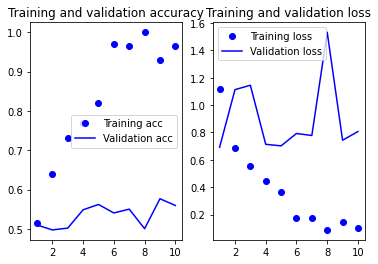

In [39]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

#plt.figure()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


The model quickly starts overfitting, unsurprisingly given the small number of training samples. Validation accuracy has high variance for 
the same reason, but seems to reach high 50s.

Note that your mileage may vary: since we have so few training samples, performance is heavily dependent on which exact 200 samples we 
picked, and we picked them at random. If it worked really poorly for you, try picking a different random set of 200 samples, just for the 
sake of the exercise (in real life you don't get to pick your training data).



We can also try to train the same model without loading the pre-trained word embeddings and without freezing the embedding layer. In that 
case, we would be learning a task-specific embedding of our input tokens, which is generally more powerful than pre-trained word embeddings 
when lots of data is available. However, in our case, we have only 200 training samples. Let's try it:

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.6951 - acc: 0.5100 - val_loss: 0.6912 - val_acc: 0.5174
Epoch 2/10
200/200 [==============================] - 1s 3ms

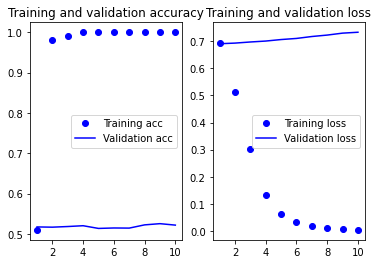

In [41]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

#plt.figure()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Validation accuracy stalls in the low 50s. So in our case, pre-trained word embeddings does outperform jointly learned embeddings. If you 
increase the number of training samples, this will quickly stop being the case -- try it as an exercise.


Finally, let's evaluate the model on the test data. First, we will need to tokenize the test data. Remember that we have created a mapping of words to indices. We now reuse this mapping by calling to `texts_to_sequences`. **You should not call to `fit_on_texts` now!** (why not?)

In [0]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

And let's load and evaluate the first model:

In [43]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 53us/sample - loss: 0.8168 - acc: 0.5583


[0.8168094424438477, 0.55828]

We get an appalling test accuracy of 54%. Working with just a handful of training samples is hard!